In [1]:
import re
import itertools
import pandas as pd

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.externals import joblib
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

import pickle


In [2]:
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/pinky/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/pinky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/pinky/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/pinky/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
#Read training data

df=pd.read_csv('data/train.csv')
df.head(6)


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0


In [4]:
#Check for missing values; remove rows with both text and title empty

print("Size of dataframe before cleanup: " + str(len(df)))
df.isnull().values.any()
df.dropna(axis=0, how='all', subset=['text', 'title'], inplace=True)
print("Size of dataframe after cleanup: " + str(len(df)))


Size of dataframe before cleanup: 20800
Size of dataframe after cleanup: 20800


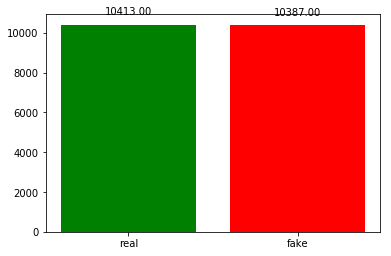

In [5]:
#Compare fake and real training dataset size to check if distribution is even/skewed

values = df['label'].value_counts()
plt.bar(x=["real", "fake"], height=values, color=["green", "red"])
for x,y in zip(["real", "fake"],values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # text
                 (x,y), # point to label
                 textcoords="offset points", # text position
                 xytext=(0,10), # distance from text to points
                 ha='center') # horizontal alignment
plt.show()


In [6]:
#Extract real data; rows with label = 0

df_reliable = df.loc[df['label'] == 0]
df_reliable.head(5)


,id,title,author,text,label
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


In [7]:
#Extract real data; rows with label = 1

df_fake = df.loc[df['label'] == 1]
df_fake.head(5)


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1


In [8]:
#Check authors' distribution

df.groupby('label')['author'].nunique()


label
0    2225
1    1981
Name: author, dtype: int64

In [9]:
df_reliable['author'].value_counts()


Pam Key                            242
Jerome Hudson                      166
Charlie Spiering                   141
John Hayward                       140
Katherine Rodriguez                124
                                  ... 
Donna De La Cruz                     1
Patrick Healy and Dalia Sussman      1
Lauren Schenkman                     1
Mark Landler and Ashley Parker       1
Dave Kehr                            1
Name: author, Length: 2225, dtype: int64

In [10]:
df_fake['author'].value_counts()


admin                                                                       193
Pakalert                                                                     86
Eddy Lavine                                                                  85
Starkman                                                                     84
Gillian                                                                      82
                                                                           ... 
HazyHotDog                                                                    1
The Tragically Hip’s Gord Downie: A True Canadian Hero - New Earth Media      1
Astronomy                                                                     1
Caleb Stephen                                                                 1
Robert Koehler                                                                1
Name: author, Length: 1981, dtype: int64

In [11]:
#Add custom field article that combines text and title into same column article

df['article'] = df['title'] + ' ' + df['text']
df.drop(columns=['title', 'text'], inplace = True)
df.head(6)


,id,author,label,article
0,0,Darrell Lucus,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,Daniel J. Flynn,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Consortiumnews.com,1,Why the Truth Might Get You Fired Why the Trut...
3,3,Jessica Purkiss,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Howard Portnoy,1,Iranian woman jailed for fictional unpublished...
5,5,Daniel Nussbaum,0,Jackie Mason: Hollywood Would Love Trump if He...


In [12]:
#Clean up and preprocess data

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

for index, row in df.iterrows():
    #Clean sentence to remove any punctuations, convert to lower case
    cleaned_sentence = re.sub(r'[^\w\s]', '', str(row['article']).lower())
    #Tokenize sentence into words
    words = nltk.word_tokenize(cleaned_sentence)
    #Remove stop words and words with length less than equal to 3
    filtered_words = [word for word in words if not word in stop_words and len(word) > 3]
    #Lemmatize
    lemmatized_sentence = ''
    for word in filtered_words:
        lemmatized_sentence = lemmatized_sentence  + ' ' + str(lemmatizer.lemmatize(word))
    
    df.loc[index, 'cleaned_article'] = lemmatized_sentence

df.head(10)


,id,author,label,article,cleaned_article
0,0,Darrell Lucus,1,House Dem Aide: We Didn’t Even See Comey’s Let...,house aide didnt even comeys letter jason cha...
1,1,Daniel J. Flynn,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",flynn hillary clinton woman campus breitbart ...
2,2,Consortiumnews.com,1,Why the Truth Might Get You Fired Why the Trut...,truth might fired truth might fired october 2...
3,3,Jessica Purkiss,1,15 Civilians Killed In Single US Airstrike Hav...,civilian killed single airstrike identified v...
4,4,Howard Portnoy,1,Iranian woman jailed for fictional unpublished...,iranian woman jailed fictional unpublished st...
5,5,Daniel Nussbaum,0,Jackie Mason: Hollywood Would Love Trump if He...,jackie mason hollywood would love trump bombe...
6,6,NaN,1,Life: Life Of Luxury: Elton John’s 6 Favorite ...,life life luxury elton john favorite shark pi...
7,7,Alissa J. Rubin,0,Benoît Hamon Wins French Socialist Party’s Pre...,benoît hamon win french socialist party presi...
8,8,NaN,0,Excerpts From a Draft Script for Donald Trump’...,excerpt draft script donald trump qampa black...
9,9,Megan Twohey and Scott Shane,0,"A Back-Channel Plan for Ukraine and Russia, Co...",backchannel plan ukraine russia courtesy trum...


In [14]:
#Sentiment analysis to see polarity difference if any between fake and real articles

df_reliable = df.loc[df['label'] == 0]
df_fake = df.loc[df['label'] == 1]

cleaned_reliable_articles = list(df_reliable['cleaned_article'])
cleaned_fake_articles = list(df_fake['cleaned_article'])

sentimentAnalyzer = SentimentIntensityAnalyzer()

#Sentiment analysis for reliable titles
sentimentscores = []
for i in cleaned_reliable_articles:
    score = sentimentAnalyzer.polarity_scores(i)
    score['article'] = i
    sentimentscores.append(score)
    
sentimentdf_reliable = pd.DataFrame(sentimentscores)

#Sentiment analysis for fake titles
sentimentscores = []
for i in cleaned_fake_articles:
    score = sentimentAnalyzer.polarity_scores(i)
    score['article'] = i
    sentimentscores.append(score)
    
sentimentdf_fake = pd.DataFrame(sentimentscores)


In [15]:
sentimentdf_reliable.head(6)


,article,compound,neg,neu,pos
0,flynn hillary clinton woman campus breitbart ...,0.8979,0.142,0.686,0.172
1,jackie mason hollywood would love trump bombe...,0.9094,0.137,0.658,0.205
2,benoît hamon win french socialist party presi...,0.9975,0.039,0.748,0.213
3,excerpt draft script donald trump qampa black...,0.9995,0.044,0.679,0.277
4,backchannel plan ukraine russia courtesy trum...,0.9968,0.079,0.768,0.153
5,obamas organizing action partner soroslinked ...,-0.5318,0.078,0.846,0.076


In [16]:
sentimentdf_fake.head(6)


,article,compound,neg,neu,pos
0,house aide didnt even comeys letter jason cha...,-0.3213,0.084,0.827,0.089
1,truth might fired truth might fired october 2...,0.9979,0.114,0.657,0.229
2,civilian killed single airstrike identified v...,-0.9988,0.370,0.571,0.058
3,iranian woman jailed fictional unpublished st...,-0.9753,0.246,0.716,0.038
4,life life luxury elton john favorite shark pi...,0.9957,0.014,0.781,0.205
5,russian researcher discover secret nazi milit...,-0.8316,0.102,0.818,0.080


In [17]:
sentimentdf_reliable.drop(columns=['article'], inplace = True)
average_sentiment_reliable = sentimentdf_reliable.mean()

sentimentdf_fake.drop(columns=['article'], inplace = True)
average_sentiment_fake = sentimentdf_fake.mean()



Sentiment_analysis..



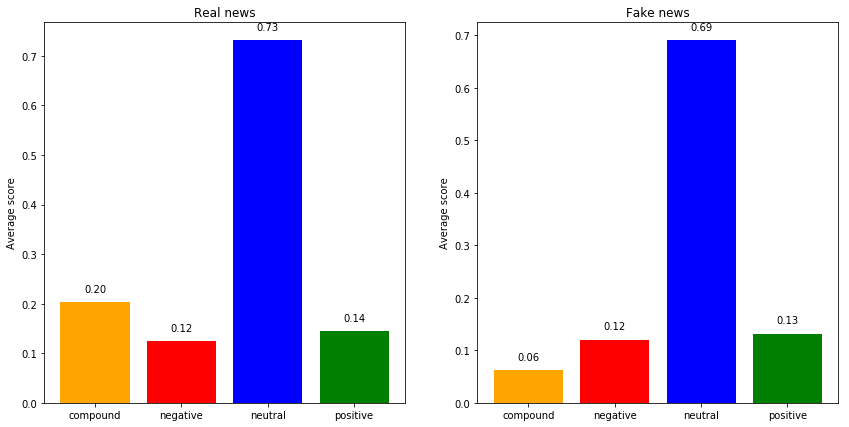

In [18]:
print("\nSentiment_analysis..\n")
names = ['compound', 'negative', 'neutral','positive']
colors=["orange", "red", "blue" , "green"]

plt.figure(figsize=(22, 7))
plt.subplot(131)
plt.bar(names,average_sentiment_reliable, color=colors)
plt.title("Real news")
plt.ylabel("Average score")
# zip joins x and y coordinates in pairs
for x,y in zip(names,average_sentiment_reliable):

    label = "{:.2f}".format(y)

    plt.annotate(label, # text
                 (x,y), # point to label
                 textcoords="offset points", # text position
                 xytext=(0,10), # distance from text to points
                 ha='center') # horizontal alignment
plt.subplot(132)
plt.bar(names,average_sentiment_fake, color=colors)
plt.title("Fake news")
plt.ylabel("Average score")
for x,y in zip(names,average_sentiment_fake):

    label = "{:.2f}".format(y)

    plt.annotate(label, # text
                 (x,y), # point to label
                 textcoords="offset points", # text position
                 xytext=(0,10), # distance from text to points
                 ha='center') # horizontal alignment

plt.show()

In [19]:
#Vectorization

In [20]:
df_x = df['cleaned_article']
df_y = df['label']
df_x.head(10)


0     house aide didnt even comeys letter jason cha...
1     flynn hillary clinton woman campus breitbart ...
2     truth might fired truth might fired october 2...
3     civilian killed single airstrike identified v...
4     iranian woman jailed fictional unpublished st...
5     jackie mason hollywood would love trump bombe...
6     life life luxury elton john favorite shark pi...
7     benoît hamon win french socialist party presi...
8     excerpt draft script donald trump qampa black...
9     backchannel plan ukraine russia courtesy trum...
Name: cleaned_article, dtype: object

In [21]:
#Unigram term frequency matrix

count_vectorizer = CountVectorizer(analyzer='word')
count_vectorizer.fit(df_x)
unigram_term_freq_matrix = count_vectorizer.transform(df_x)
print("\nunigram_term_freq_matrix:")
print(unigram_term_freq_matrix)



unigram_term_freq_matrix:
  (0, 2827)	1
  (0, 2903)	2
  (0, 3859)	1
  (0, 6446)	1
  (0, 6758)	1
  (0, 6965)	3
  (0, 7338)	1
  (0, 7431)	1
  (0, 8001)	1
  (0, 8490)	1
  (0, 8866)	6
  (0, 10649)	3
  (0, 10727)	2
  (0, 11274)	1
  (0, 11811)	1
  (0, 12371)	1
  (0, 12522)	1
  (0, 12598)	1
  (0, 13319)	1
  (0, 13551)	1
  (0, 13617)	2
  (0, 13632)	1
  (0, 15950)	1
  (0, 16707)	1
  (0, 18895)	1
  :	:
  (20799, 165355)	1
  (20799, 165418)	1
  (20799, 166351)	1
  (20799, 166596)	1
  (20799, 166677)	1
  (20799, 166737)	1
  (20799, 166748)	1
  (20799, 166765)	1
  (20799, 166812)	5
  (20799, 166827)	1
  (20799, 166828)	1
  (20799, 166920)	1
  (20799, 166992)	1
  (20799, 166999)	1
  (20799, 167041)	1
  (20799, 167230)	1
  (20799, 167250)	1
  (20799, 167276)	1
  (20799, 167288)	1
  (20799, 167442)	1
  (20799, 167443)	1
  (20799, 167447)	1
  (20799, 167505)	1
  (20799, 168122)	4
  (20799, 168633)	1


In [22]:
#Unigram tf-idf matrix

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(unigram_term_freq_matrix)
unigram_tfidf_matrix = tfidf_transformer.transform(unigram_term_freq_matrix)
print("\nunigram_tfidf_matrix:")
print(unigram_tfidf_matrix)



unigram_tfidf_matrix:
  (0, 168232)	0.050069421619470846
  (0, 168122)	0.009913118844402638
  (0, 166965)	0.045112242860588306
  (0, 166953)	0.07270698920032839
  (0, 166812)	0.03847835039711061
  (0, 166737)	0.013511088154540904
  (0, 166021)	0.06125612627411007
  (0, 164943)	0.021495720641748702
  (0, 164726)	0.01743078847938509
  (0, 164495)	0.012685866682191752
  (0, 164376)	0.03436330479689653
  (0, 164262)	0.06125612627411007
  (0, 162771)	0.029062348039435266
  (0, 162740)	0.02205724414158642
  (0, 162670)	0.017330081418286878
  (0, 159666)	0.06699844886690264
  (0, 158508)	0.035373778548680845
  (0, 158161)	0.017755871133242503
  (0, 156988)	0.0414491079565117
  (0, 156107)	0.04510879972848545
  (0, 156003)	0.0868215416447706
  (0, 156001)	0.07612285052610997
  (0, 155843)	0.024587319509754214
  (0, 155827)	0.07099875018900781
  (0, 153949)	0.04548397082019594
  :	:
  (20799, 16462)	0.028509557095345386
  (20799, 16145)	0.04753473150040301
  (20799, 15476)	0.046526398731637414

In [23]:
#Unigram and bigram term frequency matrix

count_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,2))
count_vectorizer.fit(df_x)
bigram_term_freq_matrix = count_vectorizer.transform(df_x)
print("\nbigram_term_freq_matrix:")
print(bigram_term_freq_matrix)



bigram_term_freq_matrix:
  (0, 28347)	1
  (0, 29066)	1
  (0, 34949)	2
  (0, 35902)	1
  (0, 38032)	1
  (0, 44480)	1
  (0, 44481)	1
  (0, 56445)	1
  (0, 56473)	1
  (0, 63958)	1
  (0, 64028)	1
  (0, 71733)	3
  (0, 71823)	1
  (0, 72851)	1
  (0, 73917)	1
  (0, 87221)	1
  (0, 87468)	1
  (0, 95347)	1
  (0, 96758)	1
  (0, 116792)	1
  (0, 117170)	1
  (0, 134246)	1
  (0, 135861)	1
  (0, 146535)	6
  (0, 146780)	2
  :	:
  (20799, 4211907)	1
  (20799, 4211908)	1
  (20799, 4221522)	1
  (20799, 4221523)	1
  (20799, 4221573)	1
  (20799, 4221574)	1
  (20799, 4221640)	1
  (20799, 4221641)	1
  (20799, 4221729)	1
  (20799, 4221730)	1
  (20799, 4222199)	1
  (20799, 4222200)	1
  (20799, 4222201)	1
  (20799, 4222202)	1
  (20799, 4222209)	1
  (20799, 4222210)	1
  (20799, 4222536)	1
  (20799, 4222537)	1
  (20799, 4226398)	4
  (20799, 4227909)	1
  (20799, 4229251)	1
  (20799, 4231063)	1
  (20799, 4233293)	1
  (20799, 4241123)	1
  (20799, 4241267)	1


In [24]:
#Unigram and bigram tf-idf matrix

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(bigram_term_freq_matrix)
bigram_tfidf_matrix = tfidf_transformer.transform(bigram_term_freq_matrix)
print("\nbigram_tfidf_matrix:")
print(bigram_tfidf_matrix)



bigram_tfidf_matrix:
  (0, 4235378)	0.03241195639621523
  (0, 4235376)	0.032105218768387074
  (0, 4234389)	0.02726253028841198
  (0, 4226398)	0.006356431508144326
  (0, 4203725)	0.039278291446639475
  (0, 4203297)	0.039278291446639475
  (0, 4203252)	0.028926605886906633
  (0, 4203031)	0.07544895675110866
  (0, 4202997)	0.03241195639621523
  (0, 4202694)	0.04662074613139837
  (0, 4198527)	0.039278291446639475
  (0, 4195182)	0.039278291446639475
  (0, 4194245)	0.03576690541704199
  (0, 4194182)	0.024672860548193117
  (0, 4185834)	0.039278291446639475
  (0, 4184095)	0.008663500135815693
  (0, 4162666)	0.039278291446639475
  (0, 4162665)	0.039278291446639475
  (0, 4134832)	0.03772447837555433
  (0, 4134300)	0.013783359013659992
  (0, 4130013)	0.039278291446639475
  (0, 4128818)	0.011176867224256417
  (0, 4127302)	0.030089138191623857
  (0, 4123501)	0.008134356497938377
  (0, 4121440)	0.0315568313562873
  :	:
  (20799, 149211)	0.019908571714262947
  (20799, 91550)	0.05670428718457794
  (20

In [25]:
#Unigram, bigram, trigram tf-idf matrix

tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,3))
tfidf_vectorizer.fit(df_x)
trigram_tfidf_matrix = tfidf_vectorizer.transform(df_x)
print("\ntrigram_tfidf_matrix:")
print(trigram_tfidf_matrix)



trigram_tfidf_matrix:
  (0, 11044145)	0.02531647431651331
  (0, 11044142)	0.025076886332934308
  (0, 11041662)	0.030679661679462462
  (0, 11041635)	0.021294337787346344
  (0, 11006535)	0.004964909647953334
  (0, 10930038)	0.030679661679462462
  (0, 10930037)	0.030679661679462462
  (0, 10928724)	0.030679661679462462
  (0, 10928723)	0.030679661679462462
  (0, 10928618)	0.022594121318924396
  (0, 10928034)	0.061359323358924925
  (0, 10928032)	0.05893200498135342
  (0, 10927923)	0.02531647431651331
  (0, 10927922)	0.02531647431651331
  (0, 10927082)	0.036414738673104456
  (0, 10917224)	0.030679661679462462
  (0, 10917223)	0.030679661679462462
  (0, 10904418)	0.030679661679462462
  (0, 10904417)	0.030679661679462462
  (0, 10900845)	0.030679661679462462
  (0, 10900842)	0.027936972742485838
  (0, 10900676)	0.01927158708803471
  (0, 10875405)	0.030679661679462462
  (0, 10875404)	0.030679661679462462
  (0, 10869388)	0.0067669250198392475
  :	:
  (20799, 126138)	0.025106071491571905
  (20799, 1

In [26]:
#Split data into train/test groups

In [27]:
#Unigram term frequency matrix split

train_x_unigram_tf, test_x_unigram_tf, train_y_unigram_tf, test_y_unigram_tf = train_test_split(unigram_term_freq_matrix, df_y)


In [28]:
#Unigram tf-idf matrix split

train_x_unigram_tfidf, test_x_unigram_tfidf, train_y_unigram_tfidf, test_y_unigram_tfidf = train_test_split(unigram_tfidf_matrix, df_y)


In [29]:
#Unigram and bigram term frequency matrix split

train_x_bigram_tf, test_x_bigram_tf, train_y_bigram_tf, test_y_bigram_tf = train_test_split(bigram_term_freq_matrix, df_y)


In [30]:
#Unigram and bigram tf-idf matrix split

train_x_bigram_tfidf, test_x_bigram_tfidf, train_y_bigram_tfidf, test_y_bigram_tfidf = train_test_split(bigram_tfidf_matrix, df_y)


In [31]:
#Unigram, bigram, trigram tf-idf matrix split

train_x_trigram_tfidf, test_x_trigram_tfidf, train_y_trigram_tfidf, test_y_trigram_tfidf = train_test_split(trigram_tfidf_matrix, df_y)


In [32]:

#TRAINING


In [33]:

def assess_model_performance(classifier, test_x, test_y):
    true_y = test_y
    pred_y = classifier.predict(test_x)
    print("Accuracy: " + str((classifier.score(test_x, true_y))*100) + "%")
    print("Avg macro precision: " + str(precision_score(true_y, pred_y, average='macro')))
    print("Avg micro precision: " + str(precision_score(true_y, pred_y, average='micro')))
    print("Avg macro recall: " + str(recall_score(true_y, pred_y, average='macro')))
    print("Avg micro recall: " + str(recall_score(true_y, pred_y, average='micro')))
    print("F1 Score (macro): " + str(f1_score(true_y, pred_y, average='macro')))
    print("F1 Score (micro): " + str(f1_score(true_y, pred_y, average='micro')))
    plot_confusion_matrix(classifier, test_x, true_y)
    disp = plot_precision_recall_curve(classifier, test_x, true_y)
    disp.ax_.set_title('Precision-Recall curve')
    

In [34]:
#NAIVE BAYES (MULTINOMIAL)

print("Multinomial naive bayes...")


Multinomial naive bayes...



Without smoothing, using unigram term frequency counts:
Accuracy: 92.5%
Avg macro precision: 0.9269703388319533
Avg micro precision: 0.925
Avg macro recall: 0.925105799818223
Avg micro recall: 0.925
F1 Score (macro): 0.924925325131092
F1 Score (micro): 0.925


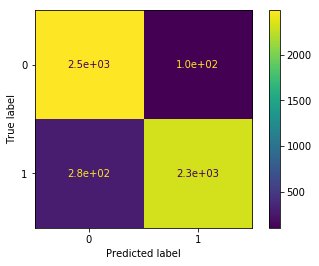

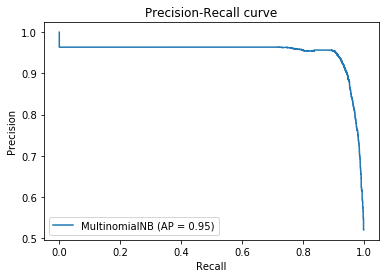

In [35]:

print("\nWithout smoothing, using unigram term frequency counts:")
mnb_unigram_tf = MultinomialNB(alpha=1.0e-10)
mnb_unigram_tf.fit(train_x_unigram_tf, train_y_unigram_tf)
assess_model_performance(mnb_unigram_tf, test_x_unigram_tf, test_y_unigram_tf)



Without smoothing, using unigram tf-idf:
Accuracy: 92.57692307692308%
Avg macro precision: 0.9277216106042909
Avg micro precision: 0.9257692307692308
Avg macro recall: 0.9256538428936796
Avg micro recall: 0.9257692307692308
F1 Score (macro): 0.9256699958154192
F1 Score (micro): 0.9257692307692308


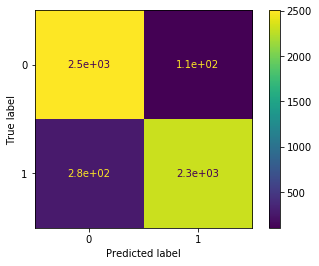

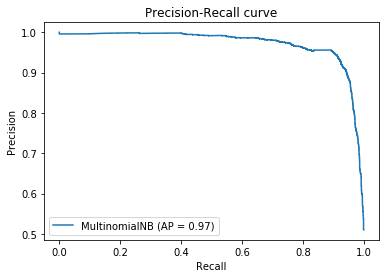

In [36]:

print("\nWithout smoothing, using unigram tf-idf:")
mnb_unigram_tfidf = MultinomialNB(alpha=1.0e-10)
mnb_unigram_tfidf.fit(train_x_unigram_tfidf, train_y_unigram_tfidf)
assess_model_performance(mnb_unigram_tfidf, test_x_unigram_tfidf, test_y_unigram_tfidf)



With smoothing, using unigram term frequency counts:
Accuracy: 90.65384615384615%
Avg macro precision: 0.9134767847819235
Avg micro precision: 0.9065384615384615
Avg macro recall: 0.9067387620237826
Avg micro recall: 0.9065384615384615
F1 Score (macro): 0.9061742064904046
F1 Score (micro): 0.9065384615384615


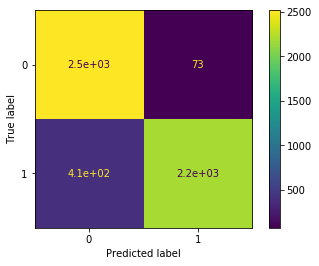

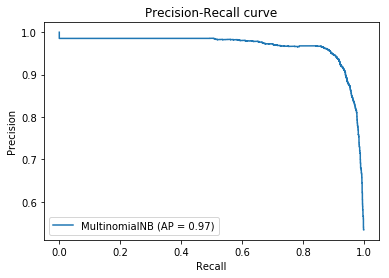

In [37]:

print("\nWith smoothing, using unigram term frequency counts:")
mnb_smoothing_unigram_tf = MultinomialNB(alpha=1.0)
mnb_smoothing_unigram_tf.fit(train_x_unigram_tf, train_y_unigram_tf)
assess_model_performance(mnb_smoothing_unigram_tf, test_x_unigram_tf, test_y_unigram_tf)



With smoothing, using unigram tf-idf:
Accuracy: 82.75%
Avg macro precision: 0.8694254302352561
Avg micro precision: 0.8275
Avg macro recall: 0.8269167870206728
Avg micro recall: 0.8275
F1 Score (macro): 0.8222822962892151
F1 Score (micro): 0.8275


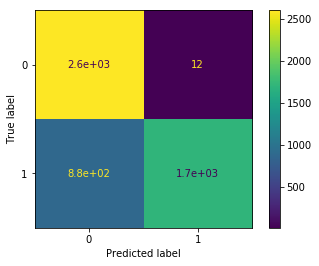

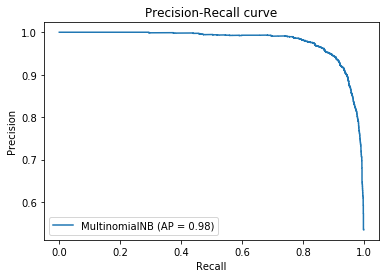

In [38]:

print("\nWith smoothing, using unigram tf-idf:")
mnb_smoothing_unigram_tfidf = MultinomialNB(alpha=1.0)
mnb_smoothing_unigram_tfidf.fit(train_x_unigram_tfidf, train_y_unigram_tfidf)
assess_model_performance(mnb_smoothing_unigram_tfidf, test_x_unigram_tfidf, test_y_unigram_tfidf)



With smoothing, using unigram and bigram term frequency counts:
Accuracy: 92.01923076923076%
Avg macro precision: 0.9279736346516008
Avg micro precision: 0.9201923076923076
Avg macro recall: 0.9202182574287363
Avg micro recall: 0.9201923076923076
F1 Score (macro): 0.9198311893005917
F1 Score (micro): 0.9201923076923076


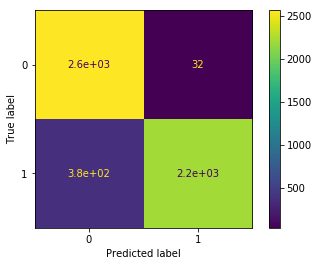

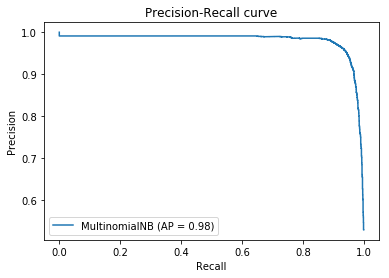

In [39]:

print("\nWith smoothing, using unigram and bigram term frequency counts:")
mnb_smoothing_bigram_tf = MultinomialNB(alpha=1.0)
mnb_smoothing_bigram_tf.fit(train_x_bigram_tf, train_y_bigram_tf)
assess_model_performance(mnb_smoothing_bigram_tf, test_x_bigram_tf, test_y_bigram_tf)



With smoothing, using unigram and bigram tf-idf:
Accuracy: 76.5%
Avg macro precision: 0.8368209255533199
Avg micro precision: 0.765
Avg macro recall: 0.7674748077291804
Avg micro recall: 0.765
F1 Score (macro): 0.7528710884997163
F1 Score (micro): 0.765


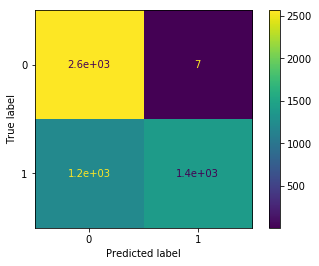

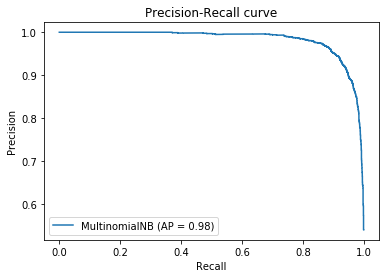

In [40]:

print("\nWith smoothing, using unigram and bigram tf-idf:")
mnb_smoothing_bigram_tfidf = MultinomialNB(alpha=1.0)
mnb_smoothing_bigram_tfidf.fit(train_x_bigram_tfidf, train_y_bigram_tfidf)
assess_model_performance(mnb_smoothing_bigram_tfidf, test_x_bigram_tfidf, test_y_bigram_tfidf)



With smoothing, using unigram, bigram and trigram tf-idf:
Accuracy: 81.82692307692308%
Avg macro precision: 0.8667392232180964
Avg micro precision: 0.8182692307692307
Avg macro recall: 0.8177796702964267
Avg micro recall: 0.8182692307692307
F1 Score (macro): 0.8118981933613842
F1 Score (micro): 0.8182692307692306


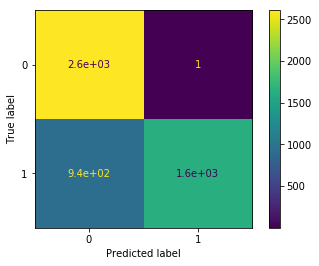

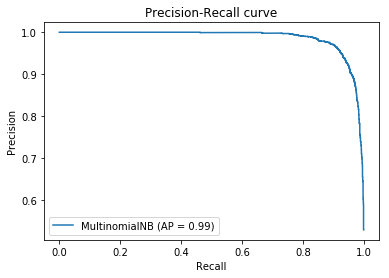

In [41]:

print("\nWith smoothing, using unigram, bigram and trigram tf-idf:")
mnb_smoothing_trigram_tfidf = MultinomialNB(alpha=1.0)
mnb_smoothing_trigram_tfidf.fit(train_x_trigram_tfidf, train_y_trigram_tfidf)
assess_model_performance(mnb_smoothing_trigram_tfidf, test_x_trigram_tfidf, test_y_trigram_tfidf)


In [42]:
#LOGISTIC REGRESSION

print("Logistic regression...")


Logistic regression...



Using unigram tf-idf:
Accuracy: 94.17307692307692%
Avg macro precision: 0.941737115759788
Avg micro precision: 0.9417307692307693
Avg macro recall: 0.9417400563527463
Avg micro recall: 0.9417307692307693
F1 Score (macro): 0.9417307498364182
F1 Score (micro): 0.9417307692307693


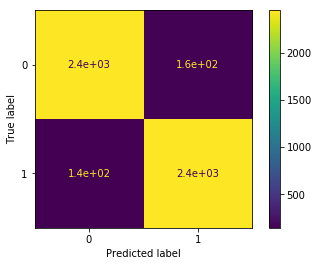

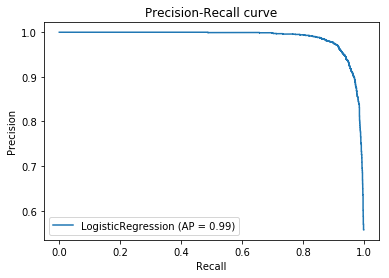

In [43]:

print("\nUsing unigram tf-idf:")
log_reg_unigram_tfidf = LogisticRegression()
log_reg_unigram_tfidf.fit(train_x_unigram_tfidf, train_y_unigram_tfidf)
assess_model_performance(log_reg_unigram_tfidf, test_x_unigram_tfidf, test_y_unigram_tfidf)



Using unigram and bigram tf-idf:
Accuracy: 93.59615384615385%
Avg macro precision: 0.9360638962163801
Avg micro precision: 0.9359615384615385
Avg macro recall: 0.93588990202414
Avg micro recall: 0.9359615384615385
F1 Score (macro): 0.9359436078834344
F1 Score (micro): 0.9359615384615385


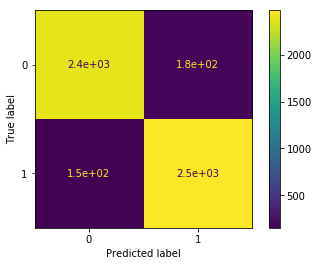

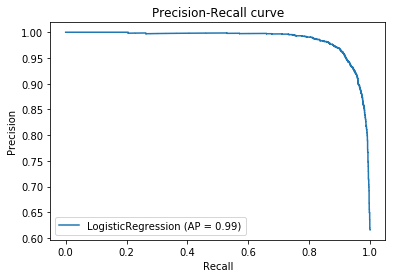

In [44]:

print("\nUsing unigram and bigram tf-idf:")
log_reg_bigram_tfidf = LogisticRegression()
log_reg_bigram_tfidf.fit(train_x_bigram_tfidf, train_y_bigram_tfidf)
assess_model_performance(log_reg_bigram_tfidf, test_x_bigram_tfidf, test_y_bigram_tfidf)



Using unigram, bigram, trigram tf-idf:
Accuracy: 93.32692307692308%
Avg macro precision: 0.9337431196355666
Avg micro precision: 0.9332692307692307
Avg macro recall: 0.9333148272820321
Avg micro recall: 0.9332692307692307
F1 Score (macro): 0.9332553462027511
F1 Score (micro): 0.9332692307692307


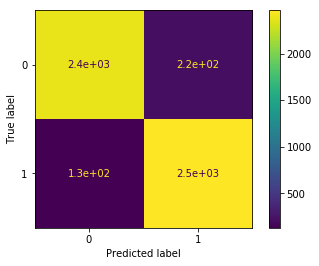

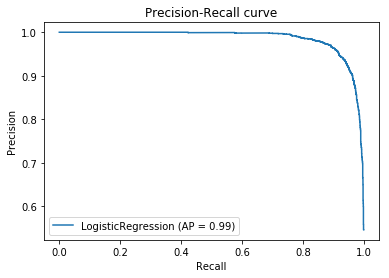

In [45]:

print("\nUsing unigram, bigram, trigram tf-idf:")
log_reg_trigram_tfidf = LogisticRegression()
log_reg_trigram_tfidf.fit(train_x_trigram_tfidf, train_y_trigram_tfidf)
assess_model_performance(log_reg_trigram_tfidf, test_x_trigram_tfidf, test_y_trigram_tfidf)


In [46]:
#SVM (Linear SVC)

print("Linear SVC...")


Linear SVC...



With linear kernel, standard regularization (inversely proportional to C) set to 1.0, using unigram tf-idf:
Accuracy: 96.07692307692308%
Avg macro precision: 0.9607699646109416
Avg micro precision: 0.9607692307692308
Avg macro recall: 0.9607754175752699
Avg micro recall: 0.9607692307692308
F1 Score (macro): 0.9607691379151193
F1 Score (micro): 0.9607692307692308


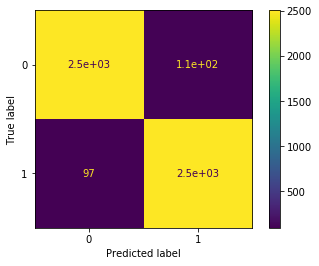

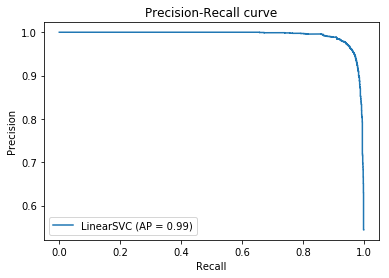

In [47]:

print("\nWith linear kernel, standard regularization (inversely proportional to C) set to 1.0, using unigram tf-idf:")

linear_svc_c1_unigram_tfidf = LinearSVC(C=1.0, max_iter=1000)
linear_svc_c1_unigram_tfidf.fit(train_x_unigram_tfidf, train_y_unigram_tfidf)
assess_model_performance(linear_svc_c1_unigram_tfidf, test_x_unigram_tfidf, test_y_unigram_tfidf)



With linear kernel, more regularization (inversely proportional to C) set to 1.0e-3, using unigram tf-idf:
Accuracy: 87.82692307692308%
Avg macro precision: 0.878496192483952
Avg micro precision: 0.8782692307692308
Avg macro recall: 0.8783123732695615
Avg micro recall: 0.8782692307692308
F1 Score (macro): 0.878258420801344
F1 Score (micro): 0.8782692307692308


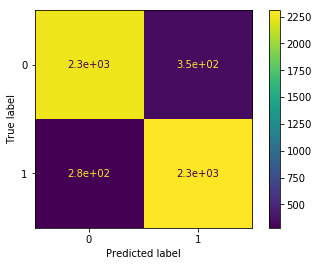

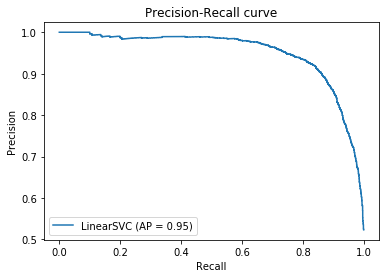

In [48]:
print("\nWith linear kernel, more regularization (inversely proportional to C) set to 1.0e-3, using unigram tf-idf:")

linear_svc_c1e3_unigram_tfidf = LinearSVC(C=1.0e-3, max_iter=1000)
linear_svc_c1e3_unigram_tfidf.fit(train_x_unigram_tfidf, train_y_unigram_tfidf)
assess_model_performance(linear_svc_c1e3_unigram_tfidf, test_x_unigram_tfidf, test_y_unigram_tfidf)



With linear kernel, standard regularization (inversely proportional to C) set to 1.0, using unigram and bigram tf-idf:
Accuracy: 96.17307692307693%
Avg macro precision: 0.9618464034512446
Avg micro precision: 0.9617307692307693
Avg macro recall: 0.961662121760867
Avg micro recall: 0.9617307692307693
F1 Score (macro): 0.9617200539603707
F1 Score (micro): 0.9617307692307693


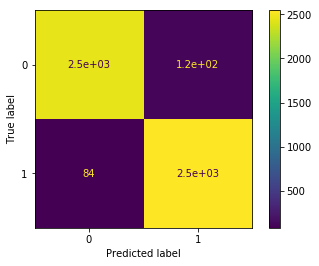

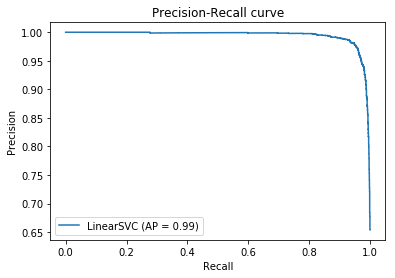

In [49]:

print("\nWith linear kernel, standard regularization (inversely proportional to C) set to 1.0, using unigram and bigram tf-idf:")

linear_svc_c1_bigram_tfidf = LinearSVC(C=1.0, max_iter=1000)
linear_svc_c1_bigram_tfidf.fit(train_x_bigram_tfidf, train_y_bigram_tfidf)
assess_model_performance(linear_svc_c1_bigram_tfidf, test_x_bigram_tfidf, test_y_bigram_tfidf)



With linear kernel, standard regularization (inversely proportional to C) set to 1.0, using unigram, bigram and trigram tf-idf:
Accuracy: 95.63461538461539%
Avg macro precision: 0.9567134461369928
Avg micro precision: 0.9563461538461538
Avg macro recall: 0.9563857045709354
Avg micro recall: 0.9563461538461538
F1 Score (macro): 0.9563397452828782
F1 Score (micro): 0.9563461538461538


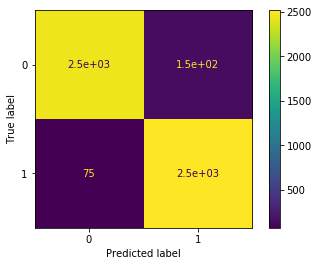

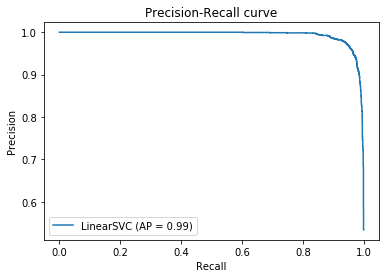

In [50]:

print("\nWith linear kernel, standard regularization (inversely proportional to C) set to 1.0, using unigram, bigram and trigram tf-idf:")

linear_svc_c1_trigram_tfidf = LinearSVC(C=1.0, max_iter=1000)
linear_svc_c1_trigram_tfidf.fit(train_x_trigram_tfidf, train_y_trigram_tfidf)
assess_model_performance(linear_svc_c1_trigram_tfidf, test_x_trigram_tfidf, test_y_trigram_tfidf)


In [51]:
#SGDC

print("SGDC...")


SGDC...



Using unigram tf-idf:
Accuracy: 95.6923076923077%
Avg macro precision: 0.956931294843818
Avg micro precision: 0.9569230769230769
Avg macro recall: 0.9569172352508958
Avg micro recall: 0.9569230769230769
F1 Score (macro): 0.9569219999730763
F1 Score (micro): 0.9569230769230769


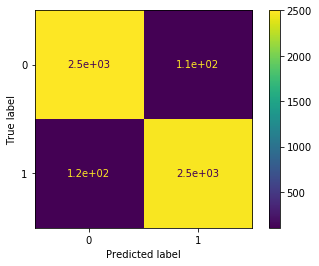

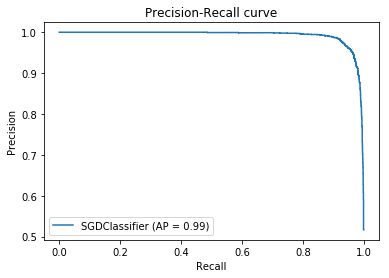

In [52]:

print("\nUsing unigram tf-idf:")
sgdc_unigram_tfidf = SGDClassifier()
sgdc_unigram_tfidf.fit(train_x_unigram_tfidf, train_y_unigram_tfidf)
assess_model_performance(sgdc_unigram_tfidf, test_x_unigram_tfidf, test_y_unigram_tfidf)



Using unigram and bigram tf-idf:
Accuracy: 95.73076923076923%
Avg macro precision: 0.9574657871255501
Avg micro precision: 0.9573076923076923
Avg macro recall: 0.9572240330831268
Avg micro recall: 0.9573076923076923
F1 Score (macro): 0.9572937369622707
F1 Score (micro): 0.9573076923076923


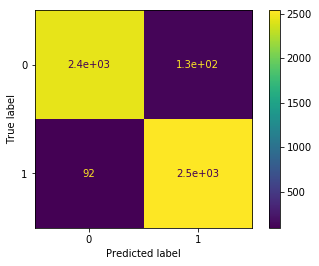

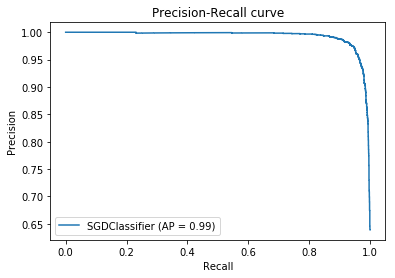

In [53]:

print("\nUsing unigram and bigram tf-idf:")
sgdc_bigram_tfidf = SGDClassifier()
sgdc_bigram_tfidf.fit(train_x_bigram_tfidf, train_y_bigram_tfidf)
assess_model_performance(sgdc_bigram_tfidf, test_x_bigram_tfidf, test_y_bigram_tfidf)



Using unigram, bigram, trigram tf-idf:
Accuracy: 95.40384615384615%
Avg macro precision: 0.9543654165317178
Avg micro precision: 0.9540384615384615
Avg macro recall: 0.9540759245148375
Avg micro recall: 0.9540384615384615
F1 Score (macro): 0.9540325439084818
F1 Score (micro): 0.9540384615384615


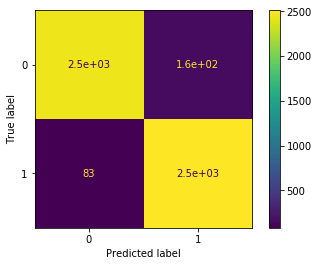

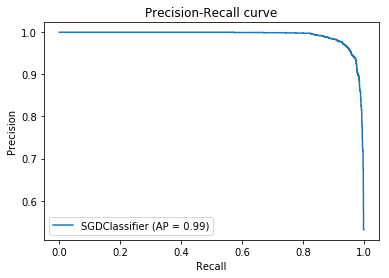

In [54]:

print("\nUsing unigram, bigram, trigram tf-idf:")
sgdc_trigram_tfidf = SGDClassifier()
sgdc_trigram_tfidf.fit(train_x_trigram_tfidf, train_y_trigram_tfidf)
assess_model_performance(sgdc_trigram_tfidf, test_x_trigram_tfidf, test_y_trigram_tfidf)


In [55]:
#DECISION TREE

print("Decision Tree...")


Decision Tree...



Using unigram tf-idf:
Accuracy: 93.46153846153847%
Avg macro precision: 0.9346158414965712
Avg micro precision: 0.9346153846153846
Avg macro recall: 0.9346132697743863
Avg micro recall: 0.9346153846153846
F1 Score (macro): 0.934614417373038
F1 Score (micro): 0.9346153846153846


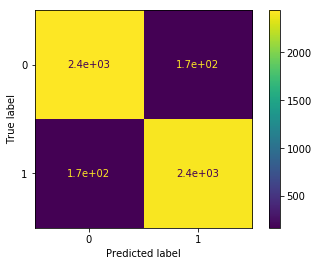

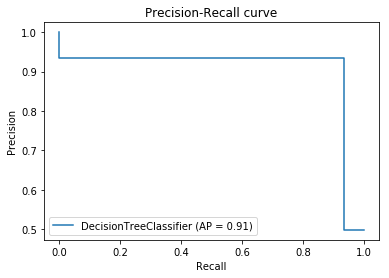

In [56]:

print("\nUsing unigram tf-idf:")
dtree_unigram_tfidf = DecisionTreeClassifier()
dtree_unigram_tfidf.fit(train_x_unigram_tfidf, train_y_unigram_tfidf)
assess_model_performance(dtree_unigram_tfidf, test_x_unigram_tfidf, test_y_unigram_tfidf)



Using unigram and bigram tf-idf:
Accuracy: 94.73076923076923%
Avg macro precision: 0.9474870838329559
Avg micro precision: 0.9473076923076923
Avg macro recall: 0.9472145882007617
Avg micro recall: 0.9473076923076923
F1 Score (macro): 0.947288970535245
F1 Score (micro): 0.9473076923076923


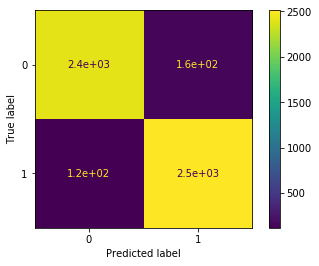

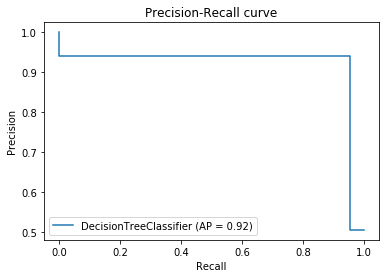

In [57]:

print("\nUsing unigram and bigram tf-idf:")
dtree_bigram_tfidf = DecisionTreeClassifier()
dtree_bigram_tfidf.fit(train_x_bigram_tfidf, train_y_bigram_tfidf)
assess_model_performance(dtree_bigram_tfidf, test_x_bigram_tfidf, test_y_bigram_tfidf)



Using unigram, bigram, trigram tf-idf:
Accuracy: 95.34615384615385%
Avg macro precision: 0.9536341091341831
Avg micro precision: 0.9534615384615385
Avg macro recall: 0.9534891599066324
Avg micro recall: 0.9534615384615385
F1 Score (macro): 0.9534587845434641
F1 Score (micro): 0.9534615384615385


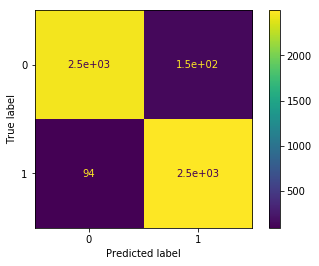

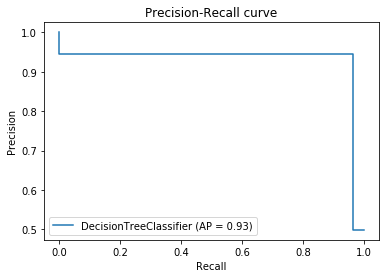

In [58]:

print("\nUsing unigram, bigram, trigram tf-idf:")
dtree_trigram_tfidf = DecisionTreeClassifier()
dtree_trigram_tfidf.fit(train_x_trigram_tfidf, train_y_trigram_tfidf)
assess_model_performance(dtree_trigram_tfidf, test_x_trigram_tfidf, test_y_trigram_tfidf)


In [60]:
def preprocessText(title, text):
    article = title + ' ' + text
    #Clean sentence to remove any punctuations, convert to lower case
    cleaned_sentence = re.sub(r'[^\w\s]', '', str(article).lower())
    #Tokenize sentence into words
    words = nltk.word_tokenize(cleaned_sentence)
    #Remove stop words and words with length less than equal to 3
    filtered_words = [word for word in words if not word in stop_words and len(word) > 3]
    #Lemmatize
    lemmatized_sentence = ''
    for word in filtered_words:
        lemmatized_sentence = lemmatized_sentence  + ' ' + str(lemmatizer.lemmatize(word))
    
    return lemmatized_sentence


In [92]:
tfidf_unigram_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,1))
sgdc_unigram_tfidf_classifier = SGDClassifier()
pipe = Pipeline([('vectorizer', tfidf_unigram_vectorizer), ('classifier', sgdc_unigram_tfidf_classifier)])
pipe.fit(df_x, df_y)
joblib.dump(pipe, './trained_model.pkl', compress=True)


['./trained_model.pkl']

In [93]:
classifier = joblib.load('./trained_model.pkl')


In [95]:
#Random test
title = "Keiser Report: Meme Wars (E995)"
text = "42 mins ago 1 Views 0 Comments 0 Likes 'For the first time in history, we‚Äôre filming a panoramic video from the station. It means you‚Äôll see everything we see here, with your own eyes. That‚Äôs to say, you‚Äôll be able to feel like real cosmonauts' - Borisenko to RT. Video presented by RT in collaboration with the Russian space agency Roscosmos and the rocket and space corporation Energia More on our project website: space360.rt.com   Subscribe   Like     Leave a Reply Login with your Social ID Your email address will not be published. Name";
article = preprocessText(title, text)
print(article)
predict = classifier.predict(pd.Series(article))
print(predict)

 keiser report meme war e995 min view comment like first time history weäôre filming panoramic video station mean youäôll everything eye thatäôs youäôll able feel like real cosmonaut borisenko video presented collaboration russian space agency roscosmos rocket space corporation energia project website space360rtcom subscribe like leave reply login social email address published name
[1]


In [96]:
#Read test data

df_test=pd.read_csv('data/test.csv')
df_test.head(6)

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...
5,20805,Trump is USA's antique hero. Clinton will be n...,NaN,Trump is USA's antique hero. Clinton will be n...


In [99]:

for index, row in df_test.iterrows():
    cleaned_sentence = preprocessText(str(row['title']), str(row['text']))
    df_test.loc[index, 'cleaned_article'] = cleaned_sentence

df_test.head(10)

,id,title,author,text,cleaned_article
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",specter trump loosens tongue purse string sil...
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,russian warship ready strike terrorist near a...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,nodapl native american leader stay winter fil...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",tebow attempt another comeback time baseball ...
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,keiser report meme war e995 min view comment ...
5,20805,Trump is USA's antique hero. Clinton will be n...,NaN,Trump is USA's antique hero. Clinton will be n...,trump usa antique hero clinton next president...
6,20806,Pelosi Calls for FBI Investigation to Find Out...,Pam Key,"Sunday on NBC’s “Meet the Press,” House Minori...",pelosi call investigation find russian donald...
7,20807,Weekly Featured Profile – Randy Shannon,Trevor Loudon,You are here: Home / *Articles of the Bound* /...,weekly featured profile randy shannon home ar...
8,20808,Urban Population Booms Will Make Climate Chang...,NaN,Urban Population Booms Will Make Climate Chang...,urban population boom make climate change wor...
9,20809,NaN,cognitive dissident,don't we have the receipt?,dont receipt


In [101]:

predict = classifier.predict(df_test['cleaned_article'])
print(predict)
print(len(predict))

[0 1 1 ... 0 1 0]
5200


In [104]:
test_id=df_test["id"]
print(test_id)

0       20800
1       20801
2       20802
3       20803
4       20804
        ...  
5195    25995
5196    25996
5197    25997
5198    25998
5199    25999
Name: id, Length: 5200, dtype: int64


In [105]:
submit_df = pd.DataFrame({"id":test_id,
                         "label":predict})
submit_df.head()


,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1


In [106]:
submit_df.to_csv("data/submit.csv", index=False)